# 准备数据

## 取数据

In [3]:
# 准备数据
import requests
import pickle

url = 'http://127.0.0.1:16018/mlApi/ocr/general-text'
files = {'image_file':open('D:\\img\\ocr\\pdf_img\\0.png','rb')}

response = requests.post(url, files=files)

with open('d:\\img\\ocr\\pdf_img\\0.data', 'wb') as fi:
    pickle.dump(response,fi)
with open ('d:\\img\\ocr\\pdf_img\\0.data','rb') as fi:
    rsp = pickle.load(fi)
data = eval(rsp.text)
words_block_list = data['words_block_list']    
print(words_block_list)




[{'words': '口', 'location': [[0, 5], [77, 5], [77, 77], [0, 77]]}, {'words': '星期', 'location': [[2089, 77], [2189, 77], [2189, 123], [2089, 123]]}, {'words': '天气', 'location': [[2428, 77], [2533, 77], [2533, 125], [2428, 125]]}, {'words': '一', 'location': [[892, 332], [960, 332], [960, 348], [892, 348]]}, {'words': '高中暑假自主学习作业本・高', 'location': [[897, 341], [1980, 341], [1980, 407], [897, 407]]}, {'words': '一', 'location': [[1930, 353], [1973, 353], [1973, 369], [1930, 369]]}, {'words': '一 -年级', 'location': [[1916, 332], [2241, 334], [2241, 405], [1916, 348]]}, {'words': 'Cyp', 'location': [[2473, 296], [2751, 296], [2751, 571], [2473, 571]]}, {'words': '语文作业一 必修一《烛之武退秦师》', 'location': [[931, 469], [2175, 469], [2175, 539], [931, 539]]}, {'words': '30000.000', 'location': [[2571, 576], [2660, 576], [2660, 589], [2571, 589]]}, {'words': '完成时间', 'location': [[1092, 598], [1302, 603], [1302, 651], [1092, 646]]}, {'words': '月', 'location': [[1520, 603], [1554, 603], [1554, 649], [1520, 649]

## 文字加粗 

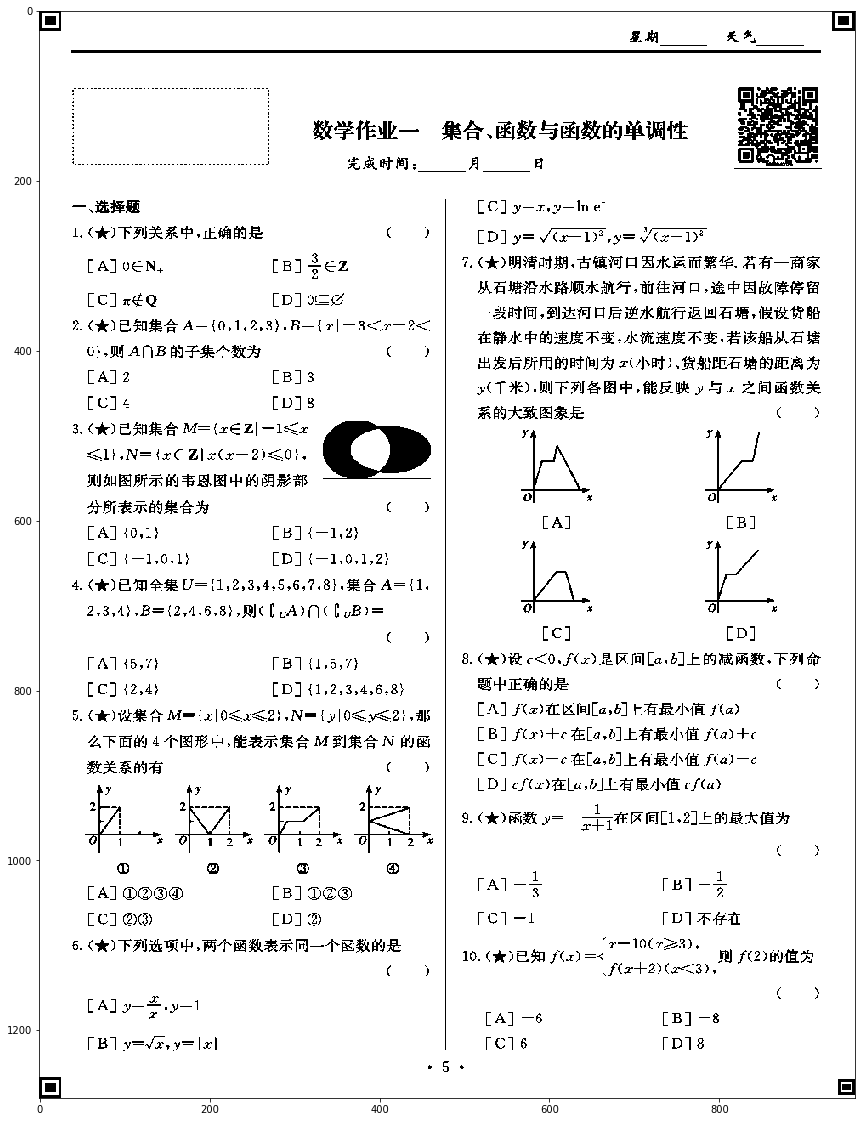

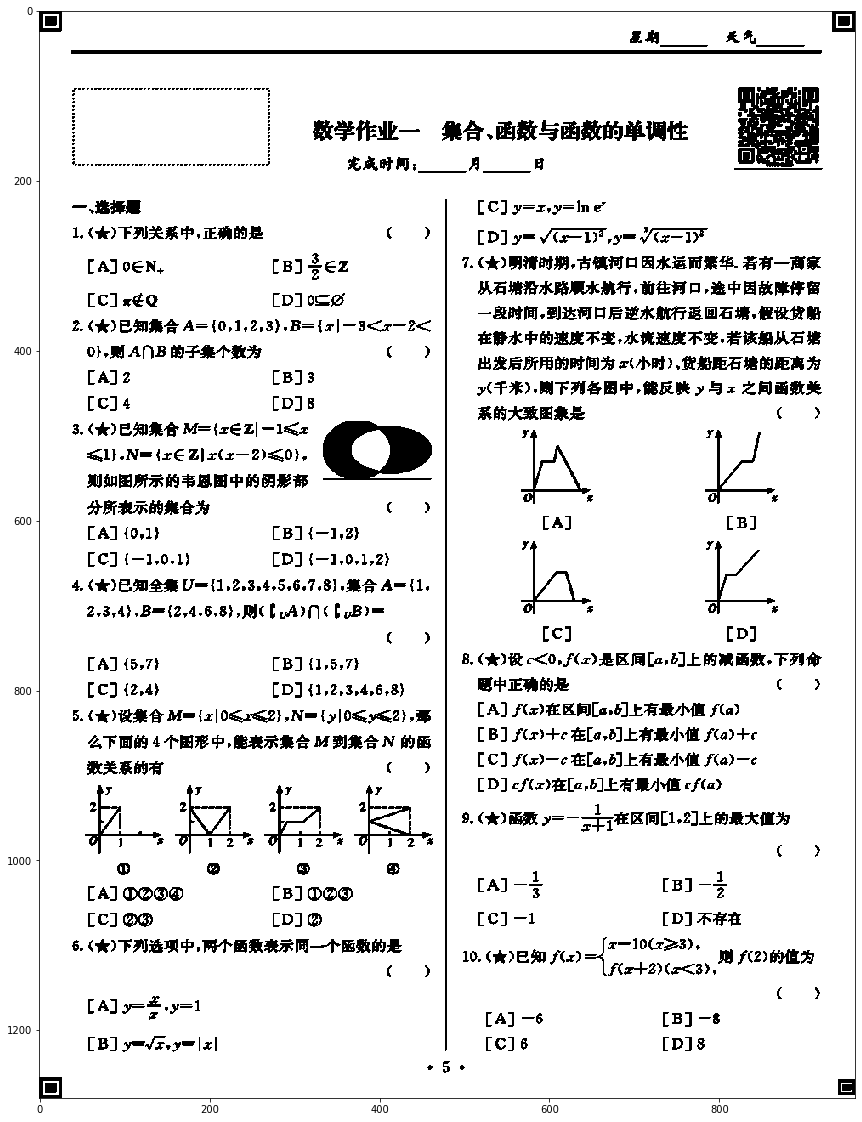

True

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
plt.rcParams['figure.figsize'] = 25, 20
image = cv2.imread('D:\\img\\ocr\\pdf_img\\4.png',cv2.IMREAD_GRAYSCALE)
_,RedThresh = cv2.threshold(image,220,255,cv2.THRESH_BINARY)
plt.imshow(RedThresh,'gray')
plt.show()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
dest = cv2.erode(RedThresh, kernel,iterations=1)
# dest = cv2.dilate(dest, kernel,iterations=1)
plt.imshow(dest,'gray')
plt.show()

cv2.imwrite('d:\\img\\ocr\\pdf_img\\0_1_2.png',dest)


# 切割试题

In [83]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
plt.rcParams['figure.figsize'] = 15, 10
image = cv2.imread('D:\\img\\ocr\\pdf_img\\0.png')

def group_text__line(words_block_list):
    words_content = np.array([x['words'] for x in words_block_list])
    words_position = [cv2.boundingRect(np.array(x['location'])) for x in words_block_list]
    words_position = np.array([[x, y, x + w, y + h] for x, y, w, h in words_position])
    position_y = np.array(sorted(set(words_position[:, 1])))
    position_y_diff = abs(position_y - np.roll(position_y, -1))
    group_y_val = position_y[np.where(position_y_diff > 5)]
    words_group_idx = [np.where(abs(words_position[:, 1] - x) <= 5)[0].tolist() for x in group_y_val]
    words_block_new_list = []
    for idx, gitem in enumerate(words_group_idx):
        sub_words_position = words_position[gitem]
        sub_words_content = words_content[gitem]
        sub_words_position = [np.min(sub_words_position[:, 0]),
                              np.min(sub_words_position[:, 1]),
                              np.max(sub_words_position[:, 2]),
                              np.max(sub_words_position[:, 3])]
        x1,y1,x2,y2 = sub_words_position
        sub_words_position = [[x1,y1],[x2,y1],[x1,y2],[x2,y2]]
        sub_words_content = ''.join(sub_words_content)
        words_block_new_list.append({'words': sub_words_content, 'location': sub_words_position})
    return words_block_new_list


def split_paragraph(words_block_list, paragraph_list):
        print('paragraph_list --> {}'.format(paragraph_list))
        words_block_array = np.array([x['location'] for x in words_block_list])
        words_contends_array = np.array([x['words'] for x in words_block_list])
        paragraph_array = np.array([x[0] for x in paragraph_list])
        print('words_block_array -->',words_block_array)
        # 取得X位置的中位数
        paragraph_x_median = np.median(words_block_array[paragraph_array, 0, 0])
        print('paragraph_x_median --> ',paragraph_x_median)
        
        paragraph_idx_filter = np.where(words_block_array[paragraph_array, 0, 0] / paragraph_x_median < 5)
        print('idx filter --> ', paragraph_idx_filter)
        paragraph_array = paragraph_array[paragraph_idx_filter]
        print('paragraph_array --> ', paragraph_array)

        print(words_block_array[paragraph_array, 0, 0] / np.median(words_block_array[paragraph_array, 0, 0]))
        paragraph_idx_list = list(zip(paragraph_array[:-1], paragraph_array[1:]))
        print('paragraph_idx_list --> {}'.format(paragraph_idx_list))
        words_position_list = [[np.min(words_block_array[x:y, :, 0]),
                                np.min(words_block_array[x:y, :, 1]),
                                np.max(words_block_array[x:y, :, 0]),
                                np.max(words_block_array[x:y, :, 1])] for x, y in paragraph_idx_list]
        words_contends_list = [' '.join(words_contends_array[x:y]) for x, y in paragraph_idx_list]
        return words_position_list,words_contends_list


paragraph_list = []
new_word_block_list = group_text__line(words_block_list.copy())
# print(new_word_block_list)
# print('new word block -->{}'.format(new_word_block_list))
# print('words blocs -->{}'.format(words_block_list[0:2]))
for idx, item in enumerate(new_word_block_list):
    # print('idx -->{} : {} --- {} '.format(idx, item['location'], item['words']))
    # 根据题号进行分隔
    if re.search('^\d+\.', item['words']) or re.search('[\u96f6\u4e00\u4e8c\u4e09\u56db\u4e94\u516d\u4e03\u516b\u4e5d\u5341\u767e\u5343\u4e07]+[,|\.|、|，]',item['words']):
        paragraph_list.append([idx, item['words']])
    elif idx == 0:
        paragraph_list.append([idx, item['words']])
paragraph_list.append([idx, item['words']])
print('paragraph_list --> {}'.format(paragraph_list))
words_position_list, words_contends_list = split_paragraph(new_word_block_list, paragraph_list)
words_lists = zip(words_contends_list, words_position_list)
print('words lists -->{}'.format(list(words_lists)))

paragraph_list --> [[0, '一高中暑假自主'], [4, '1.（★）下列句子中,加点词的解释不正确的一项是'], [9, '2.(★)下列句子中,加点词的解释不正确的一项是'], [14, '3.(★)下列何子中,加点词的解释不正确的一项是'], [19, '4.(★)下列何子中,加点词的解释不正确的一项是'], [36, '行间']]
paragraph_list --> [[0, '一高中暑假自主'], [4, '1.（★）下列句子中,加点词的解释不正确的一项是'], [9, '2.(★)下列句子中,加点词的解释不正确的一项是'], [14, '3.(★)下列何子中,加点词的解释不正确的一项是'], [19, '4.(★)下列何子中,加点词的解释不正确的一项是'], [36, '行间']]
words_block_array --> [[[ 298   86]
  [ 466   86]
  [ 298  110]
  [ 466  110]]

 [[ 311  129]
  [ 436  129]
  [ 311  151]
  [ 436  151]]

 [[ 364  170]
  [ 435  170]
  [ 364  185]
  [ 435  185]]

 [[  68  229]
  [ 138  229]
  [  68  244]
  [ 138  244]]

 [[  41  255]
  [ 427  255]
  [  41  271]
  [ 427  271]]

 [[  59  306]
  [ 360  306]
  [  59  323]
  [ 360  323]]

 [[  71  333]
  [ 395  333]
  [  71  350]
  [ 395  350]]

 [[  71  359]
  [ 361  359]
  [  71  376]
  [ 361  376]]

 [[  70  385]
  [ 359  385]
  [  70  401]
  [ 359  401]]

 [[  40  411]
  [ 427  411]
  [  40  427]
  [ 427  427]]

 [[  59  462]
  [ 360  462]
  [  5

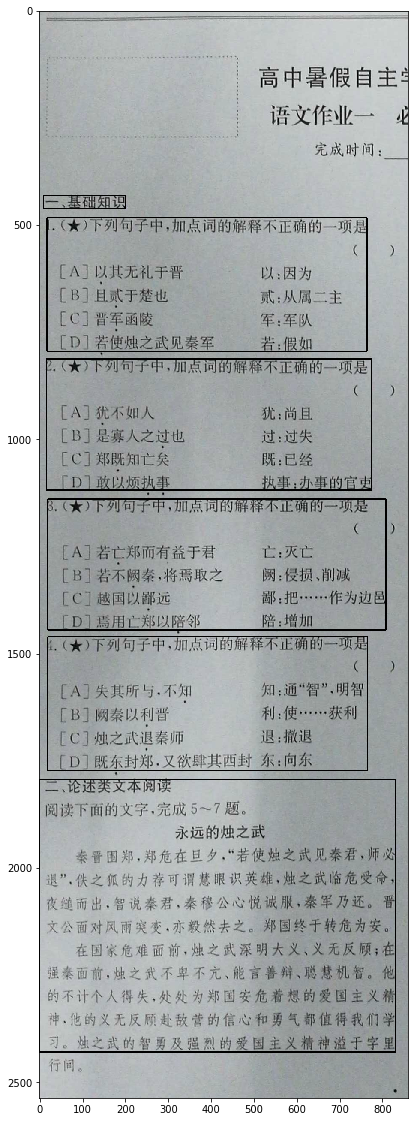

In [15]:
plt.rcParams['figure.figsize'] = 25, 20
image_paint = cv2.imread('d:\\img\\ocr\\5_1.png', cv2.IMREAD_COLOR)
for item in words_position_list:
    x,y,x2,y2 = item
    cv2.rectangle(image_paint, (x, y), (x2, y2), 0, 2)
plt.imshow(image_paint, 'brg')
plt.show()

# 试卷文字对齐 

[{'words': ['星期天气'], 'location': [1604, 58, 1946, 97]}, {'words': ['爨'], 'location': [1898, 227, 2112, 451]}]
[{'words': '星期', 'location': [[1604, 59], [1680, 59], [1680, 94], [1604, 94]]}, {'words': '天气', 'location': [[1863, 58], [1945, 58], [1945, 96], [1863, 96]]}, {'words': '数学作业一 集合、函数与函数的单调性', 'location': [[745, 319], [1758, 319], [1758, 374], [745, 372]]}, {'words': '爨', 'location': [[1898, 227], [2111, 227], [2111, 450], [1898, 450]]}, {'words': '完成时间', 'location': [[840, 422], [999, 422], [999, 459], [840, 459]]}]


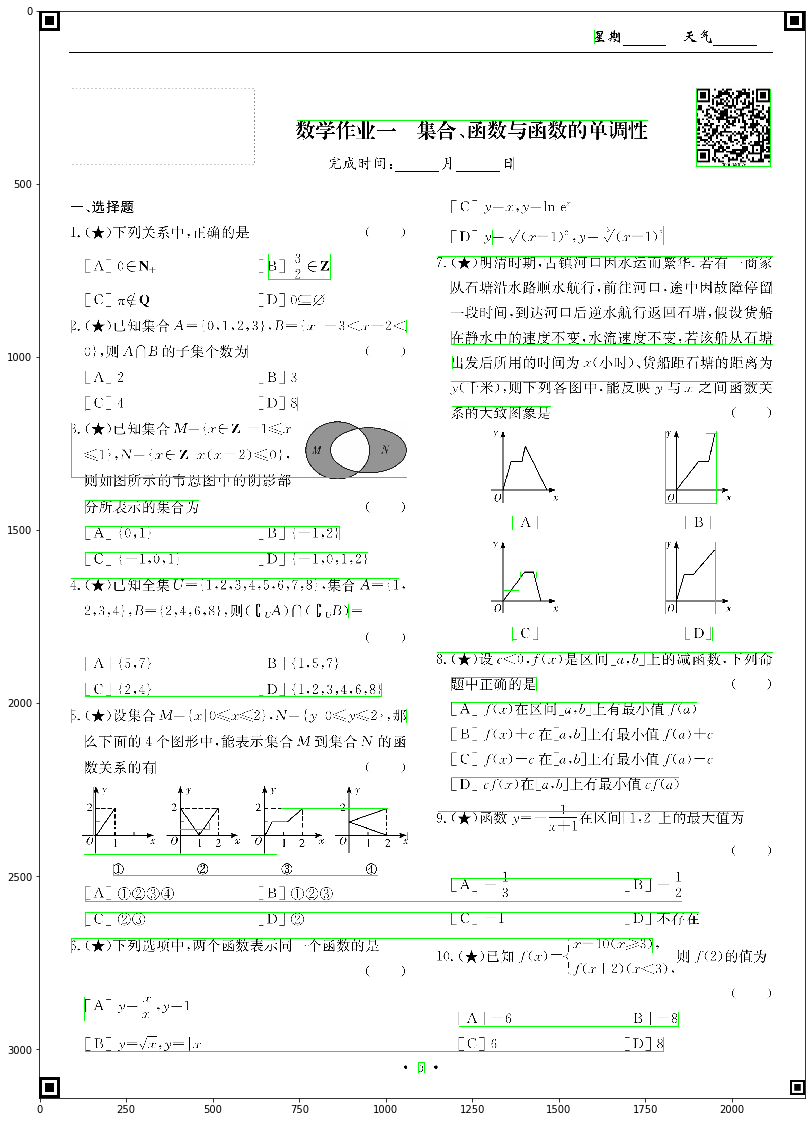

In [14]:
import cv2
import lib.text_connector.text_proposal_connector as tpc
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 25, 20
"""
用到的相关知识：
1、numpy polyfit   多项式拟合
1.1、 https://blog.csdn.net/qq_34777600/article/details/79501932  数据拟合： 直线拟合--多项式拟合
1.2、https://blog.csdn.net/castingA3T/article/details/78895479   polyfit及poly1d多项式拟合
1.3、x = [1,2,3]  y = [2,3,4]  --> p = np.polyfit(x,y,1) 拟合y=f(x) 的一阶参数 结果为[2,2.0-e3]  
     ---> f = np.poly1d(p) 得到方程式 f=2x+2.0-e3
"""
image = cv2.imread('D:\\img\\ocr\\page_5.png', cv2.IMREAD_COLOR)
def connect_proposal(text_proposals, scores, im_size):
    cp = tpc.TextProposalConnector()
    line = cp.get_text_lines(text_proposals, scores, im_size)
    return line
# def group_words_blocks(words_block_list):
words_content  = np.array([x['words'] for x in words_block_list])
words_position = [cv2.boundingRect(np.array(x['location'])) for x in words_block_list]
words_position = np.array([[x,y,x+w,y+h] for x,y,w,h in words_position])
position_y = np.array(sorted(set(words_position[:,1])))
position_y_diff = abs(position_y - np.roll(position_y,-1))
group_y_val = position_y[np.where(position_y_diff>5)]
words_group_idx = [np.where(abs(words_position[:,1]-x)<=5)[0].tolist() for x in group_y_val]

words_block_new_list = []
for idx, gitem in enumerate(words_group_idx):
    sub_words_position = words_position[gitem]
    sub_words_content = words_content[gitem]
    sub_words_position = [np.min(sub_words_position[:,0]),
                          np.min(sub_words_position[:,1]),
                          np.max(sub_words_position[:,2]),
                          np.max(sub_words_position[:,3])]
    sub_words_content = [''.join(sub_words_content)]
    words_block_new_list.append({'words':sub_words_content, 'location':sub_words_position})

print(words_block_new_list[0:2])    
print(words_block_list[0:5])

# print(position_y[group_idx])


# print(words_position.shape)
# print(words_position)
    
# group_words_blocks(words_block_list)

for item in words_block_new_list:
    x1,y1,x2,y2 = item['location']
    cv2.rectangle(image,(x1,y1),(x2,y2), (0,255,0),1 )

# mm = cv2.boundingRect(np.array([[299, 108], [464, 108], [464, 127], [299, 127]]))
# print(mm)
# x,y,w,h = mm
# print(x,y,x+w,y+h)
# cv2.rectangle(image,(x,y),(x+w,y+h), (0,255,0),1 )

cv2.imwrite('d:\\img\\ocr\\pdf_img\\0_1_1.png',image)
plt.imshow(image, 'brg')
plt.show()


# x, y, w, h = cv2.boundingRect(np.array(words_position[1]))
# print(x,y,w,h)

In [69]:
print(words_position_y)
print(abs(words_position_y - np.roll(words_position_y,-1)))

# abs(words_position_y[:-1] - words_position_y[1:])

[ 104  108  147  188  247  273  324  351  377  378  403  429  480  506
  507  533  559  585  636  637  663  688  689  714  715  741  792  793
  818  819  844  845  870  897  923  949  975 1001 1027 1053 1079 1104
 1130 1157 1183 1209]
[   4   39   41   59   26   51   27   26    1   25   26   51   26    1
   26   26   26   51    1   26   25    1   25    1   26   51    1   25
    1   25    1   25   27   26   26   26   26   26   26   26   25   26
   27   26   26 1105]


# 选择框定位

## 方式一：通过字符查找

### 字符位置定位

(304, 524, 3)
contours size -->334
cnt size -->250
0.021976232528686523


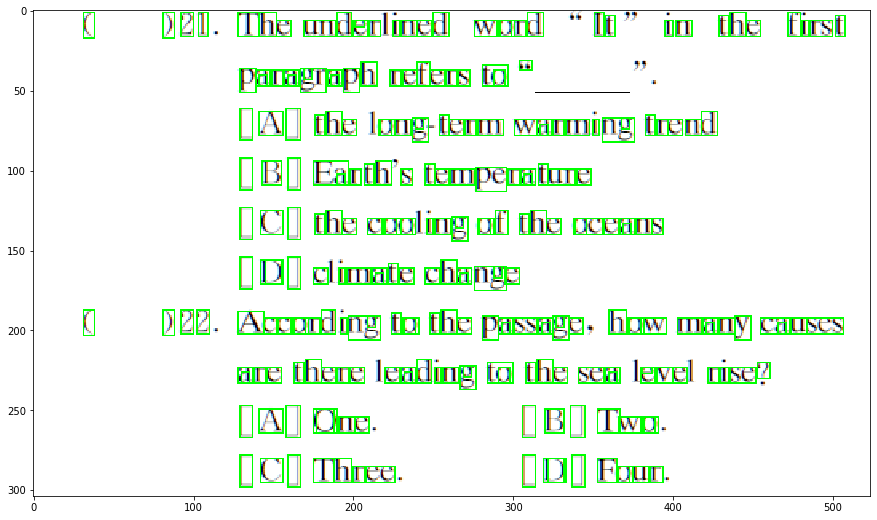

In [88]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
import time
plt.rcParams['figure.figsize'] = 15, 10
image = cv2.imread('D:\\img\\ocr\\7.png', cv2.IMREAD_COLOR)
start_time = time.time()
print(image.shape)
def check_in_areas(rect, rect_lists):
    in_area = False
    y,x,h,w = rect
    for item in rect_lists:
        iy,ix,ih,iw = item
        if y>iy and x>ix and (y+h) < (iy + ih) and (x+w) <  (ix + iw):
            in_area = True
    return in_area

image_crop = image.copy()
image_new = cv2.cvtColor(image_crop.copy(),cv2.COLOR_BGR2GRAY)
image_ocr = cv2.GaussianBlur(image_new,(3,3),0)
image_ocr = cv2.adaptiveThreshold(image_new,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
# plt.imshow(image_ocr,'gray')
# plt.show()
contours, hierarchy = cv2.findContours(image_ocr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = []
print('contours size -->{}'.format(len(contours)))
for cnt in contours:
    if cv2.contourArea(cnt) > 10:    
        rect = cv2.boundingRect(cnt)
        x,y,w,h = rect
        # 检查新增的区域是否在现有区域里面
        if w/h>0.35:
#             print(w/h)
            nrect = [y,x,h,w]
            if not check_in_areas(nrect, cnts):
                cnts.append([y,x,h,w])
                cv2.rectangle(image_crop,(x,y),(x+w,y+h),(0,255,0),1)
print('cnt size -->{}'.format(len(cnts)))
        
print(time.time() - start_time)        
# # print(cnts)
plt.imshow(image_crop,'brg')
plt.show()


### 生成选择框模拟测试数据

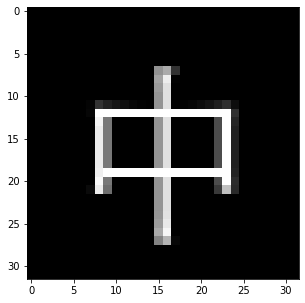

In [133]:
# https://www.cnblogs.com/skyfsm/p/8436820.html
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5
msg = '中'
img = Image.new("RGB", (32, 32), "black")
font = ImageFont.truetype('d:\\img\\ocr\\simple.ttf',size=int(32*0.7), index=0)
# ImageFont.truetype()
w, h = draw.textsize(msg,font=font)

draw = ImageDraw.Draw(img)
draw.text(((32-w)/2,(32-h)/255),msg,(255,255,255),font=font,spacing=0,align='left')
plt.imshow(img, 'brg')
plt.show()

In [125]:
??draw.text

### 训练选择框识别模型参数

### 选择框识别

In [ ]:
# 采用opencv 自带的SVM, KKN 等方式进行判别
# https://segmentfault.com/a/1190000015842888

## 方式二：通过opencv match template方式

### 准备数据  PDF转图片， PDF读文字

In [22]:
# 将PDF转成图片格式
# https://www.tutorialexample.com/best-practice-to-python-convert-pdf-to-images-for-beginners-python-tutorial/ pdf convert to images
# https://pymupdf.readthedocs.io/en/latest/
# -*- coding: utf-8 -*-
import sys, fitz 
import cv2
exam_file = 'd:\\img\\ocr\\1.pdf'
doc = fitz.open(exam_file,fontsize=18)
print(type(doc))
for idx,page in enumerate(doc):
    text = page.getText().encode('utf-8',errors='ignore')
    print(text.decode('utf-8',errors='ignore'))
    pix = page.getPixmap()
#     print(pix.width, pix.height, pix.width/pix.height)
#     zoom_x = 2212/pix.width 
#     zoom_y = 1280/pix.height
    zoom_x = 4096/pix.height
    zoom_y = 4096/pix.height
    mat = fitz.Matrix(zoom_x, zoom_y)
    pix = page.getPixmap(matrix=mat,alpha=False)
    pix.writePNG('d:\\img\\ocr\\pdf_img\\{}.png'.format(idx))
print('over')


<class 'fitz.fitz.Document'>
书
�������������
�
�
�
�
������������
�����
���高 中 暑 假 自 主 学 习 作 业 本 �高 一 年 级
���语文作业一�必修一��烛之武退秦师�
完 成 时 间 ����月 ���日
一 �基 础 知 识
�����下 列 句 子 中 �加 点 词 的 解 释 不 正 确 的 一 项 是
����
���以
�
其 无 礼 于 晋 �����以 �因 为
���且 贰
�
于 楚 也
贰 �从 属 二 主
���晋 军
�
函 陵
军 �军 队
���若
�
使 烛 之 武 见 秦 军
若 �假 如
�����下 列 句 子 中 �加 点 词 的 解 释 不 正 确 的 一 项 是
����
���犹
�
不 如 人
犹 �尚 且
���是 寡 人 之 过
�
也
过 �过 失
���郑 既
�
知 亡 矣
既 �已 经
���敢 以 烦 执 事
��
执 事 �办 事 的 官 吏
�����下 列 句 子 中 �加 点 词 的 解 释 不 正 确 的 一 项 是
����
���若 亡
�
郑 而 有 益 于 君
亡 �灭 亡
���若 不 阙
�
秦 �将 焉 取 之
阙 �侵 损 �削 减
���越 国 以 鄙
�
远
鄙 �把 ��作 为 边 邑
���焉 用 亡 郑 以 陪
�
邻
陪 �增 加
�����下 列 句 子 中 �加 点 词 的 解 释 不 正 确 的 一 项 是
����
���失 其 所 与 �不 知
�
知 �通 �智 ��明 智
���阙 秦 以 利
�
晋
利 �使 ��获 利
���烛 之 武 退
�
秦 师
退 �撤 退
���既 东
�
封 郑 �又 欲 肆 其 西 封
东 �向 东
二 �论 述 类 文 本 阅 读
阅 读 下 面 的 文 字 �完 成 ���题 �
永 远 的 烛 之 武
��秦 晋 围 郑 �郑 危 在 旦 夕 ��若 使 烛 之 武 见 秦 君 �师 必
退 ��佚 之 狐 的 力 荐 可 谓 慧 眼 识 英 雄 �烛 之 武 临 危 受 命 �
夜 缒 而 出 �智 说 秦 君 �秦 穆 公 心 悦 诚 服 �秦 军 乃 还 �晋
文 公 面 对 风 雨 突 变 �亦 毅 然 去 之 �郑 国

�������������
�
�
�
�
������������
�����
�����数学作业一�集合�函数与函数的单调性
完 成 时 间 ����月 ���日
一 �选 择 题
�����下 列 关 系 中 �正 确 的 是
����
�������
����
���
������
������
�����已 知 集 合 ������������������������
���则 ��� 的 子 集 个 数 为
����
����
����
����
����
�����已 知 集 合 �����������
���������������������
则 如 图 所 示 的 韦 恩 图 中 的 阴 影 部
分 所 表 示 的 集 合 为
����
��������
���������
�����������
�������������
�����已 知 全 集 ��������������������集 合 �����
�������������������则 ������������
����
��������
����������
��������
����������������
�����设 集 合 ������������������������那
么 下 面 的 �个 图 形 中 �能 表 示 集 合 � 到 集 合 � 的 函
数 关 系 的 有
����
�������
������
�����
����
�����下 列 选 项 中 �两 个 函 数 表 示 同 一 个 函 数 的 是
����
������
� ����
�����槡�������
������������
�
�����
�����
槡
����
� �����
槡
�
�����明 清 时 期 �古 镇 河 口 因 水 运 而 繁 华 �若 有 一 商 家
从 石 塘 沿 水 路 顺 水 航 行 �前 往 河 口 �途 中 因 故 障 停 留
一 段 时 间 �到 达 河 口 后 逆 水 航 行 返 回 石 塘 �假 设 货 船
在 静 水 中 的 速 度 不 变 �水 流 速 度 不 变 �若 该 船 从 石 塘
出 发 后 所 用 的 时 间 为 ��小 时 ��货 船 距 石 塘 的 距 离 为
��千 米 ��则 下 列 各 图 中 �能 反 映 �与 � 

over


In [24]:
??pix

In [1]:
# https://iq.opengenus.org/pdf_to_image_in_python/
# https://www.activestate.com/blog/using-python-to-convert-pdfs-to-images/
# yum install poppler poppler-cpp-devel poppler-utils
import pdf2image
from PIL import Image
import time

#DECLARE CONSTANTS
PDF_PATH = "d:\\img\\ocr\\1.pdf"
DPI = 300
OUTPUT_FOLDER = None
FIRST_PAGE = None
LAST_PAGE = None
FORMAT = 'png'
THREAD_COUNT = 1
USERPWD = None
USE_CROPBOX = False
STRICT = True
pil_images = pdf2image.convert_from_path(PDF_PATH, 
                                         dpi=DPI, 
                                         output_folder=OUTPUT_FOLDER, 
                                         first_page=FIRST_PAGE, 
                                         last_page=LAST_PAGE, 
                                         fmt=FORMAT, 
                                         thread_count=THREAD_COUNT, 
                                         userpw=USERPWD, 
                                         use_cropbox=USE_CROPBOX, 
                                         strict=STRICT)
print(len(pil_images))
index = 1
for image in pil_images:
    image.save("d:\\img\\ocr\\page_" + str(index) + ".png")
    index += 1


9


In [127]:
# https://blog.csdn.net/Asher117/article/details/89203780
import camelot
import pandas as pd
tables = camelot.read_pdf(filepath='d:\\img\\ocr\\1.pdf',pages='4',flavor='stream')
df = pd.DataFrame(tables[0].data)

In [128]:
df

,0,1,2
0,\n\n,,
1,佚之狐的话师必退表现了佚之狐对烛之武\n,,有时散文的发展推动了时代政治经济和思\n
2,的了解与信任使读者未见其人先知其才从,,想文化背景
3,反面表现了烛之武的才能,,时代政治经济和思想文化背景有时推动了\n
4,烛之武退秦师中的主要人物是烛之武作者\n,,散文的发展
5,通过他的语言不管是牢骚还是说辞都表现,,时代政治经济和思想文化背景决定了散文\n
6,了他不仅能言善辩而且深明大义机智勇敢,,的发展
7,烛之武退秦师一文中除去主体说辞部分层\n,\n,文中画横线的部分有语病下列修改最恰当\n
8,层深入步步紧逼之外首尾几个自然段的叙,的一项是,\n\n
9,事尽管文字简洁情节的推进变化却是波澜,,宋代欧阳修苏轼等人也对语言进行了丰富\n


In [122]:
??TextConverter

In [29]:
??page.getText

### 定位选择框 

In [15]:
# https://blog.csdn.net/qq_41603898/article/details/82219291 python实现 opencv 学习笔记---模板匹配matchTemplate
# https://www.gaitubao.com/pdf-to-jpg/ 在线pdf 转 图片
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
import time
plt.rcParams['figure.figsize'] = 25, 20
image = cv2.imread('d:\\img\\ocr\\pdf_img\\0.png', cv2.IMREAD_COLOR)


print('image shape -->{}'.format(image.shape))
tpl = cv2.imread('D:\\img\\ocr\\stemplate.png')
th, tw = tpl.shape[:2]
result = cv2.matchTemplate(image, tpl, cv2.TM_SQDIFF_NORMED)
print('result -->{}'.format(result))
print('result len -->', np.array(result).shape)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
tl = min_loc
print('compare result -->{}'.format(result[454][407]))
print('min result ', np.min(result))
print('tl -->{}, min val -->{}'.format(tl, min_val))
br = (tl[0] + tw, tl[1] + th)
cv2.rectangle(image,tl,br,(0,255,0),2)
# plt.imshow(image,'brg')
# print(image.shape)
# plt.show()
# print(min_loc)

image shape -->(1280, 960, 3)
result -->[[0.3792589  0.36273333 0.33803394 ... 0.33591124 0.36531895 0.39049047]
 [0.35087568 0.33502144 0.31107193 ... 0.30888125 0.33757317 0.36195245]
 [0.3224621  0.3072836  0.28405395 ... 0.28145126 0.30991033 0.33353037]
 ...
 [0.32321003 0.3074544  0.28369966 ... 0.18946914 0.21899392 0.2497973 ]
 [0.35155106 0.3350932  0.31060937 ... 0.167315   0.19428992 0.2222424 ]
 [0.38000453 0.3628662  0.33762574 ... 0.14593086 0.17011166 0.1950538 ]]
result len --> (1263, 906)
compare result -->0.002725699683651328
min result  0.0027256997
tl -->(407, 454), min val -->0.002725699683651328


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

# 填空题区域定位

In [74]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
plt.rcParams['figure.figsize'] = 25, 20
image = cv2.imread('D:\\img\\ocr\\pdf_img\\3_0.png',cv2.IMREAD_GRAYSCALE)


# image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)

# img = cv2.GaussianBlur(image,(5,5),0)
ret,img = cv2.threshold(image,140,255,cv2.THRESH_BINARY_INV)
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
cols = img.shape[1]

horizontal_size = int(cols / 20)
print('horizontal_size ---->', horizontal_size)
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
img = cv2.erode(img, horizontalStructure)
# plt.imshow(img,'gray')
# plt.show()

img = cv2.dilate(img, horizontalStructure)
# img = cv2.blur(img, tuple((3, 3)))
# element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((5, 5)), (-1, -1))
# img = cv2.dilate(img, element, iterations=1)
# plt.imshow(img,'gray')
# plt.show()
minLineLength = int(img.shape[1] * 0.1)
print('min Line length -->{}'.format(minLineLength))
lines = cv2.HoughLinesP(img, 1, np.pi / 180, 20, minLineLength=minLineLength, maxLineGap=1000)
print('lines array -->', lines)
if lines:
    print('------------------------------------------------')
else:
    print('=================================================')
lines = np.array(lines)

lines = lines.reshape(-1,4)
print('line shape -->{}'.format(lines.shape))
image = cv2.imread('D:\\img\\ocr\\pdf_img\\3_0.png')

exmr = []
for line in lines:
    x1, y1, x2, y2 = line
    width = abs(x2-x1)
    hight = abs(y2-y1)
    x1,y1,width,hight = int(10*round(x1/10)), int(10*round(y1/10)), int(10*round(width/10)), int(10*round(hight/10))
    print('------------>',x1,y1,width, hight)
    exmr.append([x1,y1,width,hight])

#     if int(100 * width/img.shape[1]) <= 30 and int(100 * width/img.shape[1]) >= 20:
#         # 进行四舍五入操作,为后期排重做准备
#         exmr.append([x1,y1,width,hight,int(100 * width/img.shape[1])])
        
exmr = np.array(exmr)
print(len(exmr))
# 根据Y轴进行排重
va,inx = np.unique(exmr[:,1] + exmr[:,0],return_index=True)
exmr = exmr[inx]

# exmr = exmr[exmr[:,2]>200]
idex = np.lexsort([exmr[:, 0], exmr[:, 1]])
exmr = exmr[idex,:]

print('exmr index length --->', exmr)

for x1, y1, w, h in exmr:
    print('--->',x1, y1, x2, y2)
    cv2.line(image, (x1, y1), (x1+w, y1+h), (0,255,0), 1)

plt.imshow(image,'brg')
plt.show()

# plt.imshow(img,'gray')
# plt.show()


horizontal_size ----> 65
min Line length -->130
lines array --> None


ValueError: cannot reshape array of size 1 into shape (4)

# 正则式

In [41]:
# encoding: utf-8
import re
s = ['基础知识','下列句子中加点词的解释不正确的一项是']
split_token = [',','.','、','，','。']
number_1 = ['1','2','3','4','5','6','7','8','9','0']
number_2 = ['一','二','三','四','五','六','七','八','九','十']
number_3 = ['Ⅰ','Ⅱ','Ⅲ','Ⅳ','Ⅴ','Ⅵ','Ⅶ','Ⅷ','Ⅸ','Ⅹ']
longs = []
for num in number_1[:-1]:
    for token in split_token:
        longs.extend([''.join([num,token,x]) for x in s]  )
    for sub_num in number_1:
        for token in split_token:
          longs.extend([''.join([num,sub_num,token,x]) for x in s]  )
        
for num in number_2:
    for token in split_token:
        longs.extend([''.join([num,token,x]) for x in s]  )
        
for num in number_3:
    for token in split_token:
        longs.extend([''.join([num,token,x]) for x in s]  )

longs.append('2 . 基础知识')
longs.append('（)22. According to the passage, how many causes')
longs.append('2 . 基础知识')
parrten = re.compile(r'[\d|一二三四五六七八九十|ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩ]{1,2}[\.|,|、|，|。]')
total_number = len(longs)
match_number = 0
not_match_number = 0
match_filter_s = ['(',')','（', '）','C','c',' ']
for item in longs:
    match_s =''.join([x for x in item[0:10] if x not in match_filter_s])
    
    if parrten.match(match_s):
        match_number+=1
#         print('matched --->',item)
    else:
        not_match_number+=1
        print('not matched --->',item)

print('total number :{} match number :{}'.format(total_number, match_number))
        
# print(longs)
    

total number :1192 match number :1192


# 特征区

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
import time
import math
plt.rcParams['figure.figsize'] = 15, 10
# https://segmentfault.com/a/1190000014008224 稀疏矩阵
# https://blog.csdn.net/u012101561/article/details/90348288  稀疏矩阵压缩
# https://www.tutorialspoint.com/opencv/opencv_box_filter.htm box filter : used to min , averge, max 
'''
方式一：任意截取某一区域大小的图片，进行二值化，然后将数据与其它需比较的图片相同区域进行比较。对二进制图片按行（或按列）进行压缩
组成多个数字。如0101=5
'''
image1 = cv2.imread('D:\\img\\ocr\\pdf_img\\0000.png')
image1 = cv2.resize(image1, (960,1280), interpolation=cv2.INTER_AREA)
crop1 = image1[300:360, 400:520]
crop1 = cv2.resize(crop1, (10,20),interpolation=cv2.INTER_LINEAR)
crop1 = crop1.reshape((3, crop1.shape[0], crop1.shape[1]))
print(crop1.shape)
crop1_mean =  np.mean(crop1, axis=0)
def match_area(image_src, image_dest):
    image_src = np.mean(image_src, axis=0, dtype=np.int)
    image_dest = np.mean(image_dest, axis=0, dtype=np.int)
    result = (image_src - image_dest) ** 2
    result = np.sum(result)
    return result

def match_area_2(image_src, image_dest):
    image_src = np.mean(image_src, axis=0, dtype=np.int)
    image_dest = np.mean(image_dest, axis=0, dtype=np.int)
    result = np.sqrt(np.sum(np.square(image_src-image_dest)))
#     result = np.dot(image_src,image_dest)/(np.linalg.norm(image_src)*(np.linalg.norm(image_dest)))
    return result

# Distance based on cosine similarity
def match_area_3(image_src, image_dest):
    image_src = np.mean(image_src, axis=0, dtype=np.int)
    print('shape -->', image_src.shape)
    image_dest = np.mean(image_dest, axis=0, dtype=np.int)
    dot = np.sum(np.multiply(image_src, image_dest), axis=1)
    norm = np.linalg.norm(image_src, axis=1) * np.linalg.norm(image_dest, axis=1)
    similarity = dot / norm
    dist = np.arccos(similarity) / math.pi    
    return dist



image_crop_list = []
for idx in range(8):
    image_tmp = cv2.imread('D:\\img\\ocr\\pdf_img\\{}.png'.format(idx))
    image_tmp = cv2.resize(image_tmp, (960,1280), interpolation=cv2.INTER_AREA)
    crop_tmp = image_tmp[300:360, 400:520]
    crop_tmp = cv2.resize(crop_tmp, (10,20),interpolation=cv2.INTER_LINEAR)
    crop_tmp = crop_tmp.reshape((3, crop_tmp.shape[0], crop_tmp.shape[1]))
    image_crop_list.append(crop_tmp.copy())
print(len(image_crop_list))

start_time = time.time()
for idx, crop2 in enumerate(image_crop_list):
    print('idx{} match result -->{}'.format(idx, match_area(crop1, crop2)))
print('over time {}'.format(time.time() - start_time))

(3, 20, 10)
8
idx0 match result -->320422
idx1 match result -->372647
idx2 match result -->354724
idx3 match result -->418025
idx4 match result -->358169
idx5 match result -->341116
idx6 match result -->301520
idx7 match result -->337071
over time 0.0009996891021728516


In [23]:
import base64
import numpy as np
crop_tmp_mean = np.mean(crop_tmp, axis=0, dtype=np.int)
crop_tmp_mean = crop_tmp_mean.reshape(-1)
crop_unique = np.unique(crop_tmp_mean[np.where(crop_tmp_mean != 255)[0]])
print(len(crop_unique), len(np.where(crop_tmp_mean != 255)[0]))
print(crop_unique)
print(np.where(crop_tmp_mean != 255)[0])
# (np.where(crop_tmp_mean != 255)[0])

70 948
[144 153 162 170 171 172 177 178 180 182 185 186 187 189 191 192 193 194
 195 196 198 202 203 204 205 206 208 209 210 211 212 213 215 216 217 218
 219 220 221 222 223 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 246 247 248 249 250 251 252 253 254]
[ 234  235  236  237  238  239  309  310  311  312  313  314  315  316
  317  318  319  320  321  322  323  594  595  596  597  598  599  660
  661  662  663  664  665  675  676  677  678  679  680  681  682  683
  954  955  956  957  958  959 1017 1018 1019 1020 1021 1022 1023 1024
 1025 1035 1036 1037 1038 1039 1040 1041 1042 1043 1314 1315 1316 1317
 1318 1319 1374 1375 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1391 1395 1396 1397 1398 1399 1400 1401 1402
 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413 1414 1415 1428
 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1674 1675 1676
 1677 1678 1679 1734 1735 1736 1737 1738 1739 1740 1741 1742 1743 174

# 调试

(1280, 960, 3)


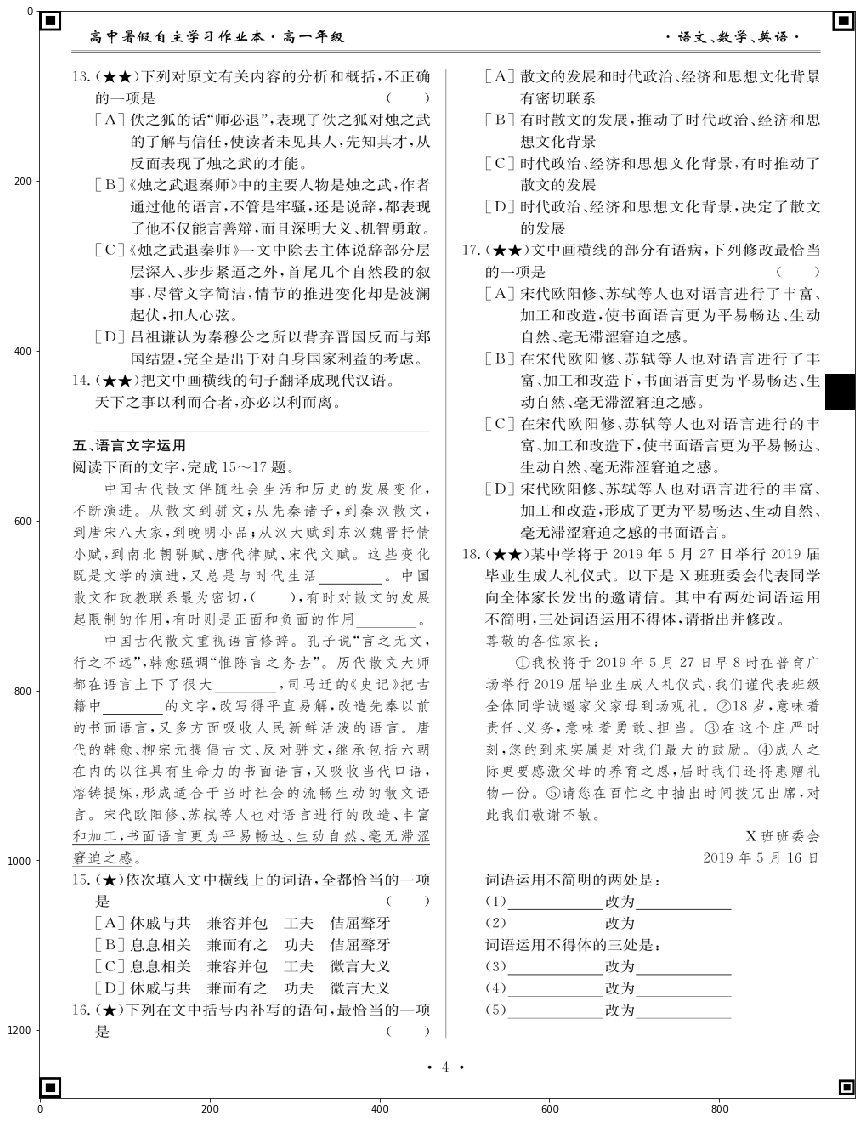

In [67]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import copy
plt.rcParams['figure.figsize'] = 25, 20

image = cv2.imread('d:\\img\\ocr\\page_4.png', cv2.IMREAD_COLOR)
image = cv2.resize(image, (960,1280),interpolation=cv2.INTER_AREA)
print(image.shape)
# x:40, y:428, w:368, h:42,
x,y,w,h = [925,428,368,42]
cv2.rectangle(image, (x, y), (x + w, y + h), 0, -1)
plt.imshow(image,'brg')
plt.show()